In [437]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

### Download sequences

In [438]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0   1578      0 --:--:-- --:--:-- --:--:--  1578
100 36.2M  100 36.2M    0     0  20.7M      0  0:00:01  0:00:01 --:--:-- 23.9M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    734      0 --:--:-- --:--:-- --:--:--   734
100 14.2M  100 14.2M    0     0  11.3M      0  0:00:01  0:00:01 --:--:-- 17.1M
+ bash scripts/

In [439]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [440]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [441]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [442]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [443]:
df.reason.value_counts()

N                             303636
X                             214170
A[B.1.1.7]                     35832
A[B.1.617.2]                   35493
Y                              25489
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [444]:
import re

In [445]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    x = pd.crosstab(d.lineage.cat.remove_unused_categories() == "None", d.sequencing_pc).T
    #print((x[True] / x.sum(1)).sort_values())
    print(x)

lineage        False  True 
sequencing_pc              
1127.0            74      0
12489.0           55      0
1307.0          1123      2
13353.0          931      3
14467.0         2354      4
1458.0           929     13
16321.0         4248     20
17475.0         1353     16
20095.0         3951      6
20251.0          994      0
21502.0        11420     54
22081.0         2940      8
23845.0          203      0
30159.0         8916     13
30167.0           86      0
30449.0           69      0
3048.0           305      4
32105.0         1639     10
32545.0          763      2
32758.0          227      0
35043.0            3      0
37075.0          171      0
40210.0         2838     16
40225.0         4015     16
40477.0         1653      5
4103.0          1368     13
44137.0         7887      2
44879.0         4194    133
45147.0          315      5
4779.0         35552    544
50858.0        20172    181
50933.0         1926     38
55128.0            4      0
55131.0         1100

In [446]:
import re
d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")

IMS_ID
IMS-10294-CVDP-87A74412-A73F-4B65-AA1B-1D2F60BAD700    False
IMS-10294-CVDP-307E544A-42F4-487F-A925-D7A6E5A3D20E    False
IMS-10294-CVDP-7E903449-A7EF-4A04-8A14-278C1D6C6E68    False
IMS-10294-CVDP-59FB4C41-BD0E-48BC-AC35-73356B52044A    False
IMS-10294-CVDP-1A233FB2-B135-4F49-BFDF-AE612E2E9BF7    False
                                                       ...  
IMS-10280-CVDP-99B02515-7562-45EA-BB2C-87D66EDC9C5A    False
IMS-10280-CVDP-26043A7F-B937-4CC3-B6E2-FB8DFF8DB5F7    False
IMS-10280-CVDP-4B2F46B9-2BF1-44BE-8204-FEDC020940DA    False
IMS-10280-CVDP-254A4EF3-4576-46A6-8A24-3F676EE0A3BE    False
IMS-10280-CVDP-33B72BFB-43B4-4117-82D9-33C8AEC9CD57    False
Name: lineage, Length: 262697, dtype: bool

In [447]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-28     0       0     0     0      0          0
                  2022-03-01     0       0     0     0      0          0
                  2022-03-02     0       0     0     0      0          0
                  2022-03-03     0       0     0     0      0          0
                  2022-03-04     0       0     0     0      0          0

[1984 rows x 6 columns]

In [448]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland                                                         
Baden-Württemberg       15712   16725  6632     4     30      41413
Bayern                   2585    3640  2248     0     29       6202
Berlin                    690     678   735     0      5       2888
Brandenburg               907    1283   792     1      0       2851
Bremen                    177     267     2     0      5        837
Hamburg                  3889    3224  1100     3     23       3767
Hessen                    957    1480   466     2      1       1643
Mecklenburg-Vorpommern    562     543   380     0      0       2824
Niedersachsen             950    1052   481     0      6       3018
Nordrhein-Westfalen     18590   18811  7508    13    161      26429
Rheinland-Pfalz           292     254    65     0      2       1510
Saarland                  718     992   147     0      4       1776
Sachsen                  4768    6651  2042     2     30      15054
Sachsen-Anhalt           1622     476   687     3      0       3003
Schleswig-Holstein       3099    4102  1812     4      2       3907
Thüringen                 297     491   101     0      8       1702

In [449]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [450]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [451]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [452]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A15-A34      W          2022-03-10  2022-03-10   
            A35-A59      W          2022-03-10  2022-03-10   
            A60-A79      W          2022-03-10  2022-03-10   
            A80+         W          2022-03-10  2022-03-10   
            unbekannt    W          2022-03-10  2022-03-10   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A15-A34      W          2022-03-10                     0   
            A35-A59      W          2022-03-10                     0   
            A60-A79      W          2022-03-10                     0   
            A80+         W          2022-03-10                     0   
            unbekannt    W          2022-03-10                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A15-A34      W          2022-03-10          1              -9   
            A35-A59      W          2022-03-10          1              -9   
            A60-A79      W          2022-03-10          1              -9   
            A80+         W          2022-03-10          1              -9   
            unbekannt    W          2022-03-10          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A15-A34      W          2022-03-10          -9          47   
            A35-A59      W          2022-03-10          -9          82   
            A60-A79      W          2022-03-10          -9          20   
            A80+         W          2022-03-10          -9          11   
            unbekannt    W          2022-03-10          -9           1   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [453]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

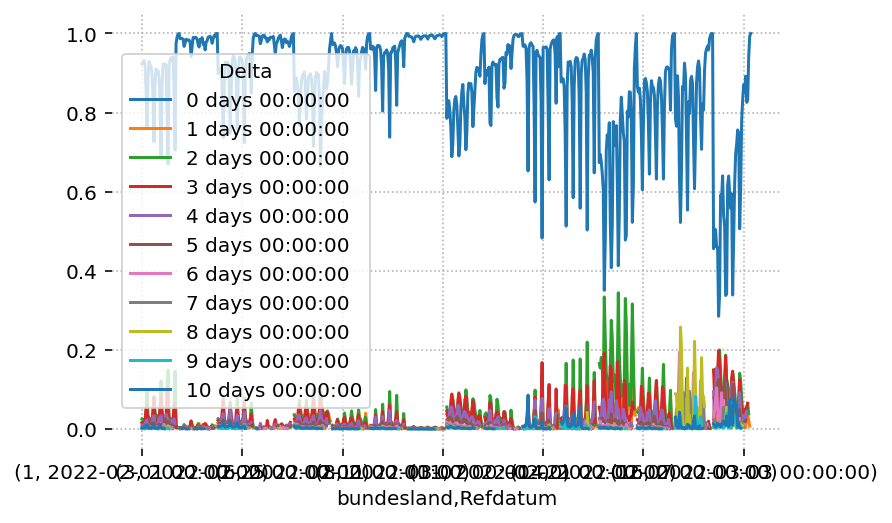

In [454]:
f.plot()

In [455]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [456]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [457]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.934850         0.951021         0.973372         0.984088   
Wed             0.933183         0.952163         0.968569         0.978795   
Thu             0.934539         0.943845         0.959260         0.964109   
Fri             0.914734         0.927978         0.937050         0.961685   
Sat             0.835017         0.845756         0.892443         0.954209   
Sun             0.710391         0.759085         0.877472         0.947601   
Mon             0.903299         0.929419         0.962299         0.979974   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.989179         0.990655         0.994620         0.996661   
Wed             0.981565         0.989411         0.994975         0.997188   
Thu             0.979368         0.991792         0.995865         0.997785   
Fri             0.982590         0.991870         0.994689         0.995927   
Sat             0.981073         0.988753         0.990533         0.991673   
Sun             0.972736         0.979336         0.984129         0.985702   
Mon             0.986841         0.990348         0.991917         0.994997   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997836         0.997553               1.0  
Wed             0.998331         0.998714               1.0  
Thu             0.998359         0.997257               1.0  
Fri             0.996947         0.997048               1.0  
Sat             0.993181         0.994649               1.0  
Sun             0.991551         0.994083               1.0  
Mon             0.997018         0.998467               1.0

In [458]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [459]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [460]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999843  0.999822  0.999564  0.999305  0.998333   
Bayern                  0.997647  0.996115  0.991792  0.984382  0.967872   
Berlin                  0.996781  0.996130  0.993931  0.977294  0.920229   
Brandenburg             0.992819  0.991018  0.988072  0.971848  0.921522   
Bremen                  1.000000  1.000000  1.000000  0.998404  0.995336   
Hamburg                 0.999419  0.999236  0.998810  0.998256  0.995324   
Hessen                  0.999462  0.999122  0.998563  0.996909  0.991981   
Mecklenburg-Vorpommern  0.998706  0.997062  0.995641  0.992186  0.971713   
Niedersachsen           0.995592  0.994099  0.991348  0.982592  0.955520   
Nordrhein-Westfalen     0.997725  0.996898  0.993293  0.989369  0.974505   
Rheinland-Pfalz         0.998970  0.998701  0.997968  0.994407  0.979415   
Saarland                0.998731  0.998624  0.998064  0.997704  0.986804   
Sachsen                 0.998943  0.997875  0.996521  0.992331  0.982482   
Sachsen-Anhalt          0.992654  0.996154  0.978500  0.866636  0.753903   
Schleswig-Holstein      0.998331  0.997785  0.994689  0.988753  0.972736   
Thüringen               0.978008  0.956885  0.961177  0.951504  0.868601   

                               5         6         7         8  
Baden-Württemberg       0.997561  0.997223  0.996091  0.995281  
Bayern                  0.946114  0.926061  0.907014  0.887401  
Berlin                  0.987899  0.984002  0.977215  0.972265  
Brandenburg             0.973993  0.967752  0.949618  0.943123  
Bremen                  0.997394  0.996547  0.993356  0.990564  
Hamburg                 0.995693  0.991659  0.991040  0.987620  
Hessen                  0.990412  0.987401  0.979160  0.972704  
Mecklenburg-Vorpommern  0.958709  0.940592  0.842935  0.796982  
Niedersachsen           0.964017  0.963967  0.952358  0.943488  
Nordrhein-Westfalen     0.968463  0.950815  0.932318  0.913874  
Rheinland-Pfalz         0.989455  0.982336  0.975689  0.973162  
Saarland                0.976888  0.975191  0.964224  0.953190  
Sachsen                 0.976001  0.966724  0.934650  0.899366  
Sachsen-Anhalt          0.857371  0.872919  0.872448  0.931844  
Schleswig-Holstein      0.979974  0.973372  0.952163  0.934539  
Thüringen               0.841217  0.822356  0.764427  0.722250

In [461]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [462]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4427        4621   
Bayern                        5946        7033        9174        8948   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1072        1058   
Bremen                          79          89          69          62   
Hamburg                        320         456         537         496   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1674        1370   
Nordrhein-Westfalen           2542        3409        4304        4313   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9243        8800        7230        9345   
Berlin                        1450         967         753        2173   
Brandenburg                   1187        1119         978        1260   
Bremen                          55          55          31          60   
Hamburg                        548         461         406         470   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4039        3727        2885        4339   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3191        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         448   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-01  2022-03-02  \
bundesland                                      ...                           
Baden-Württemberg             7123        7754  ...       28734       30251   
Bayern                       11246       12150  ...       31334       38924   
Berlin                        1919        2395  ...        6481        6584   
Brandenburg                   1494        1686  ...        8178        7328   
Bremen                         143          95  ...         912        1062   
Hamburg                        526         566  ...        2660        2312   
Hessen                        1791        2067  ...        9777       10656   
Mecklenburg-Vorpommern         597         468  ...        5870        5246   
Niedersachsen                 1754        2165  ...       19448       19034   
Nordrhein-Westfalen           5147        5384  ...       34289       37064   
Rheinland-Pfalz               1139        1329  ...        9008        8424   
Saarland                       273         301  ...        2367        2314   
Sachsen                       5756        5986  ...       12255       10772   
Sachsen-Anhalt                1019        1178  ...        6906        6971   
Schleswig-Holstein             486         542  ...        5770       

In [463]:
cases_land.sum(0)

Refdatum
2021-11-01     22380
2021-11-02     27177
2021-11-03     32127
2021-11-04     31407
2021-11-05     32498
               ...  
2022-03-06     78444
2022-03-07    154303
2022-03-08    223703
2022-03-09    225091
2022-03-10    168772
Length: 130, dtype: int64

In [464]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4427        4621   
Bayern                        5946        7033        9174        8948   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1072        1058   
Bremen                          79          89          69          62   
Hamburg                        320         456         537         496   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1674        1370   
Nordrhein-Westfalen           2542        3409        4304        4313   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9243        8800        7230        9345   
Berlin                        1450         967         753        2173   
Brandenburg                   1187        1119         978        1260   
Bremen                          55          55          31          60   
Hamburg                        548         461         406         470   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4039        3727        2885        4339   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3191        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         448   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-28  2022-03-01  \
bundesland                                      ...                           
Baden-Württemberg             7123        7754  ...       20167       28734   
Bayern                       11246       12150  ...       23583       31334   
Berlin                        1919        2395  ...        6479        6481   
Brandenburg                   1494        1686  ...        5197        8178   
Bremen                         143          95  ...         556         912   
Hamburg                        526         566  ...        1800        2660   
Hessen                        1791        2067  ...        7221        9777   
Mecklenburg-Vorpommern         597         468  ...        2954        5870   
Niedersachsen                 1754        2165  ...       11340       19448   
Nordrhein-Westfalen           5147        5384  ...       22690       34289   
Rheinland-Pfalz               1139        1329  ...        6666        9008   
Saarland                       273         301  ...        1013        2367   
Sachsen                       5756        5986  ...        8151       12255   
Sachsen-Anhalt                1019        1178  ...        3972        6906   
Schleswig-Holstein             486         542  ...        5209       

In [465]:
C = cases_land.values

In [466]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [694]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=4) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

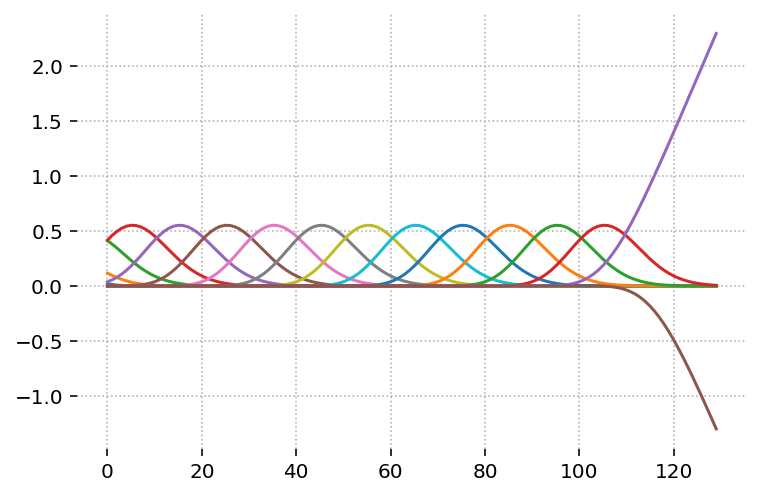

In [695]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [696]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [697]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [698]:
from numpyro.infer import Trace_ELBO

In [699]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [700]:
CC[2,-2] = np.nan 

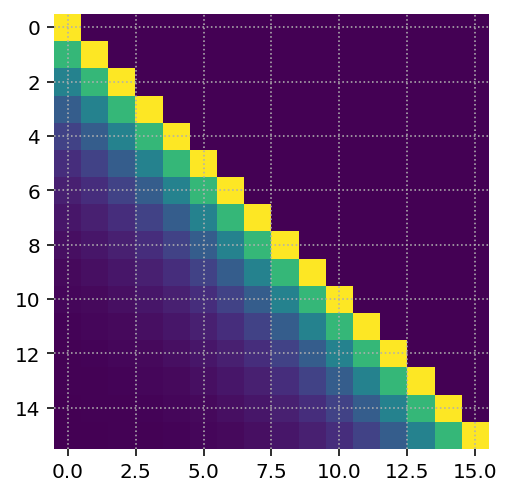

In [701]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [707]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.001,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [708]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

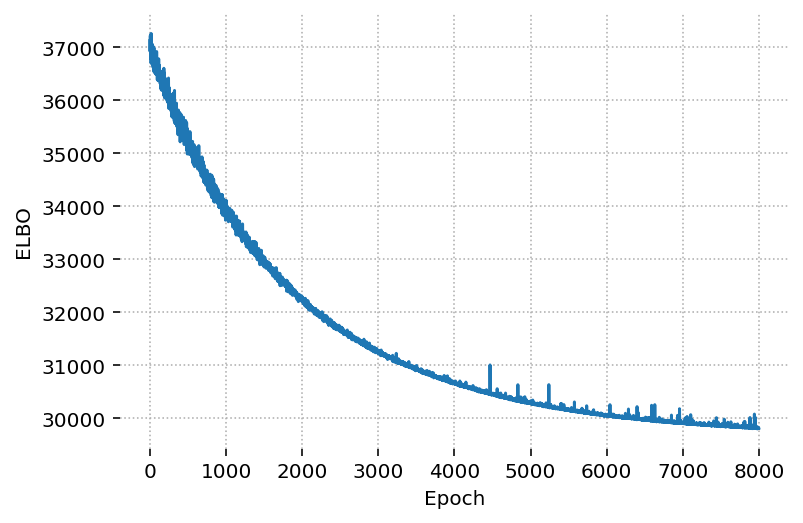

In [709]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

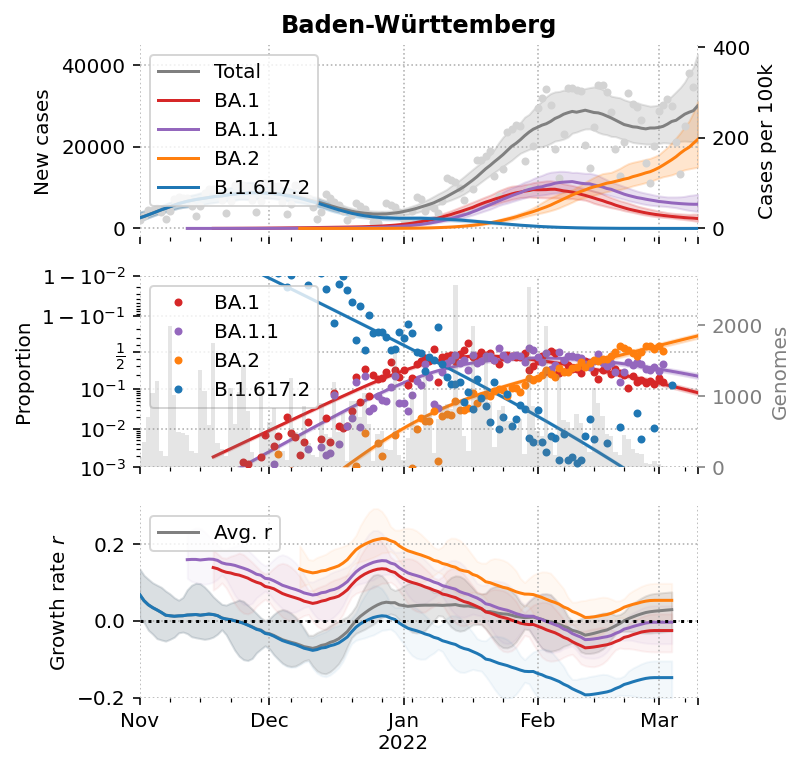

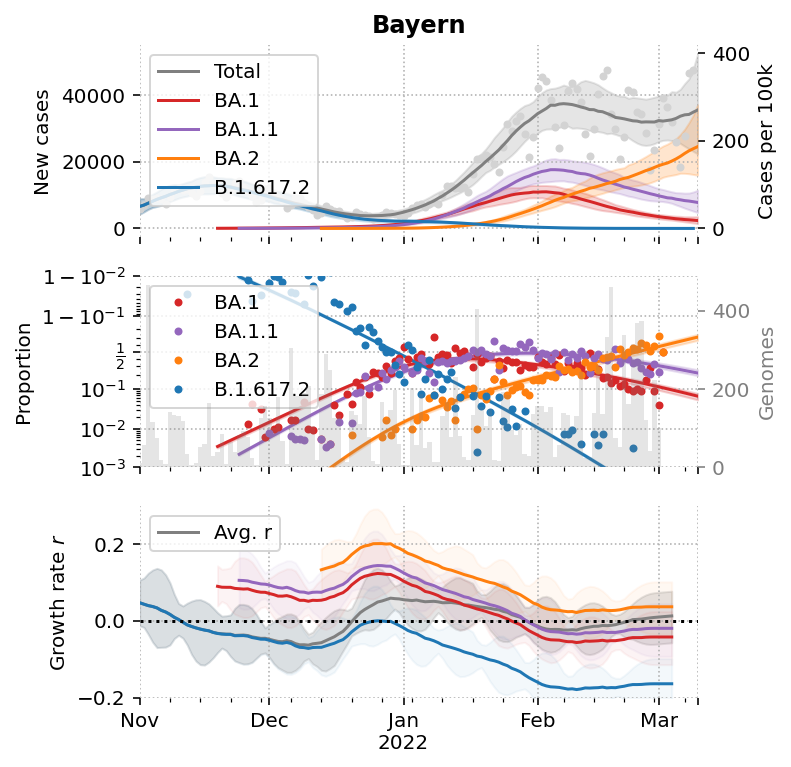

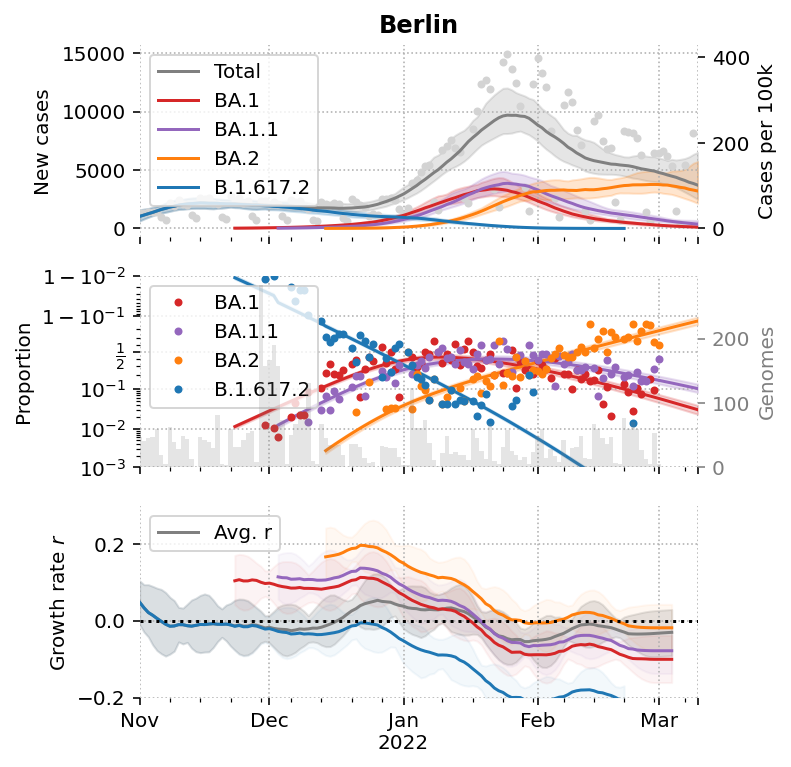

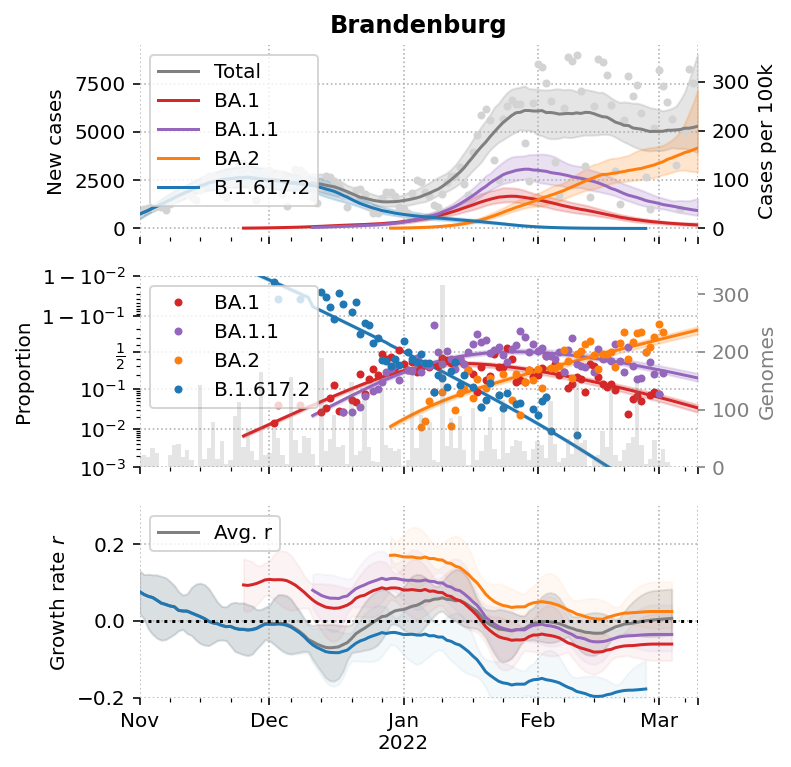

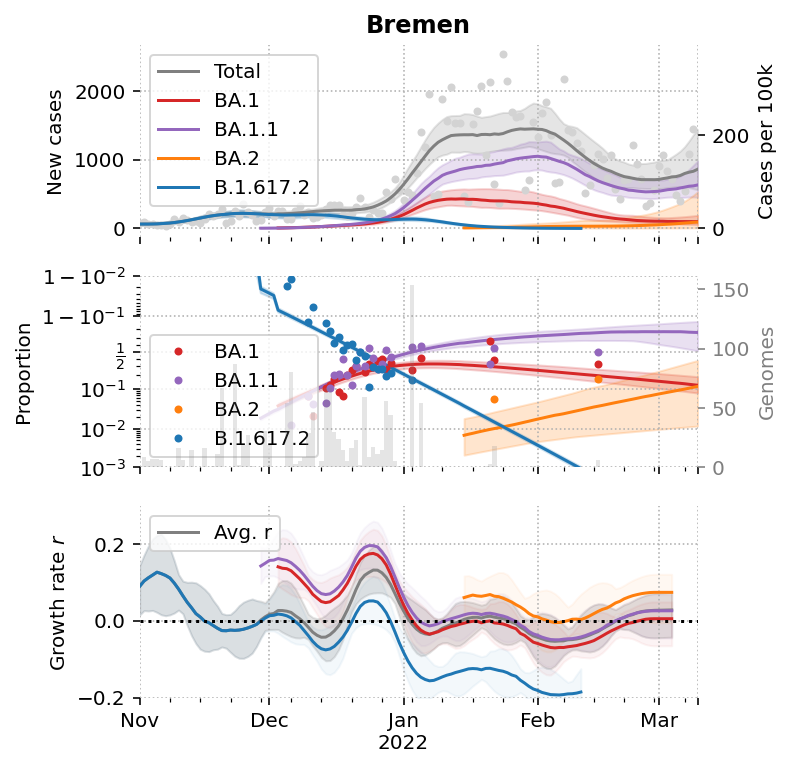

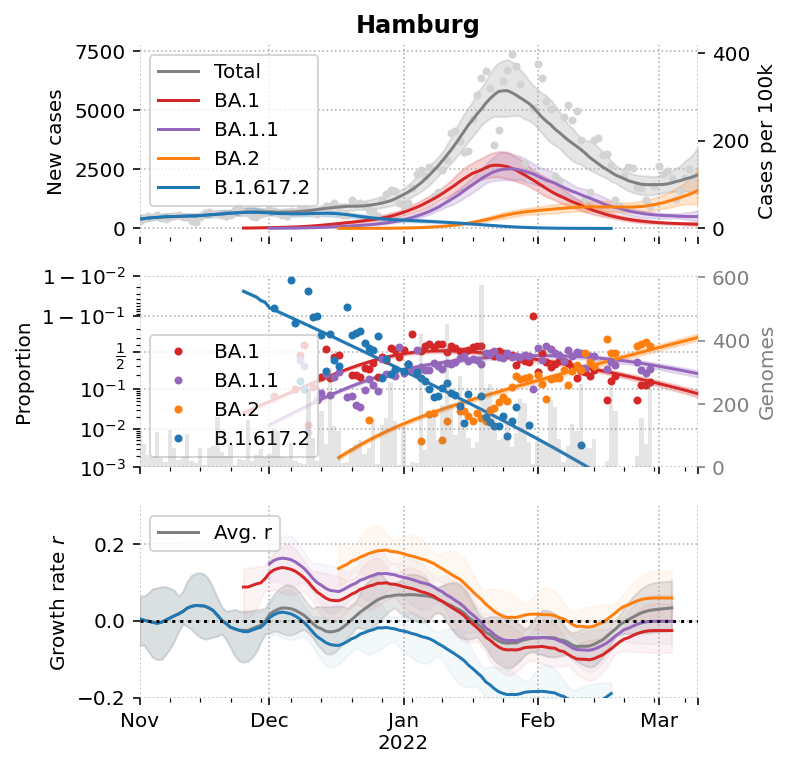

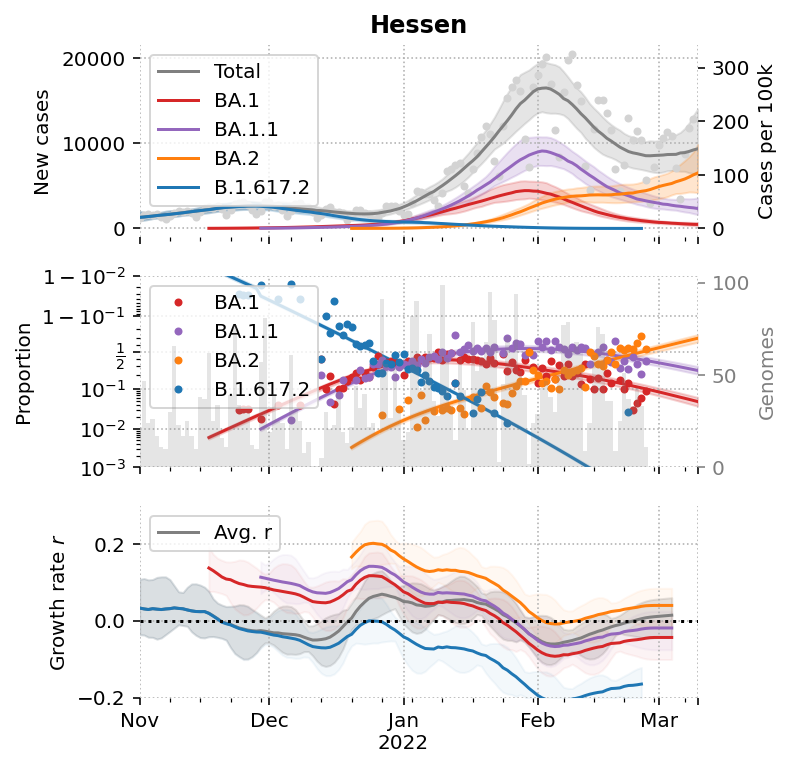

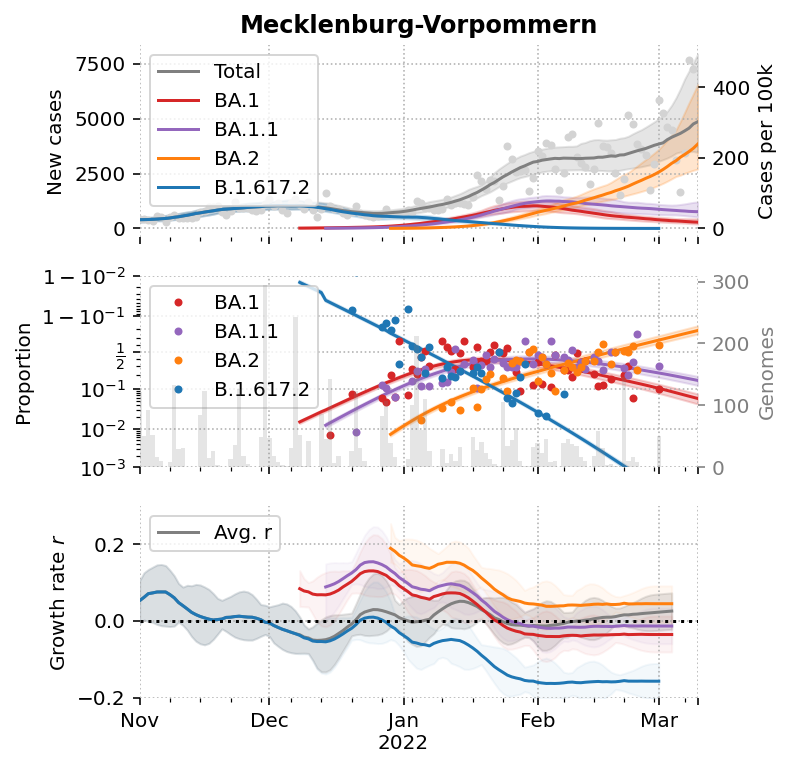

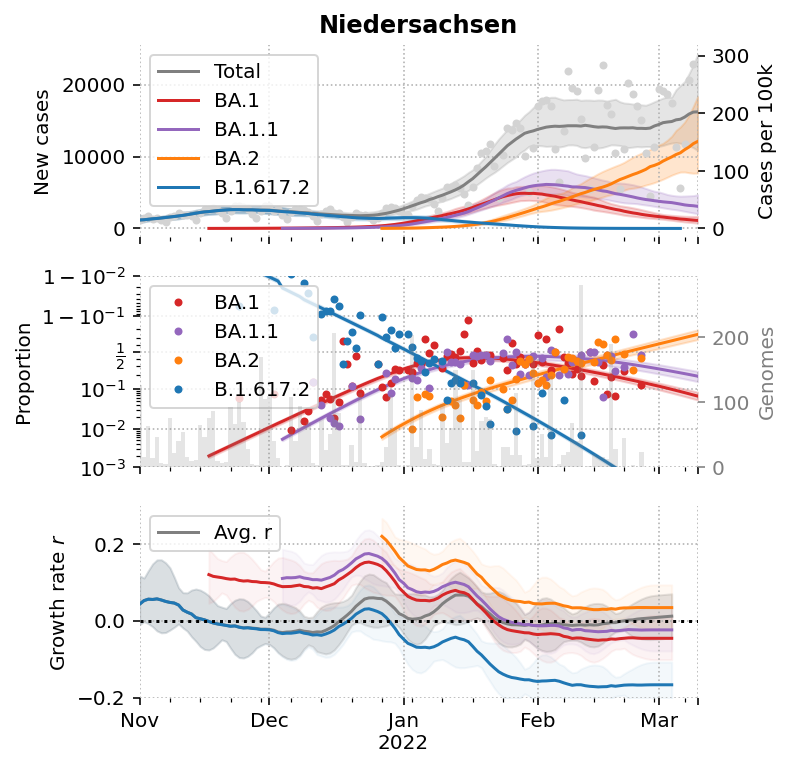

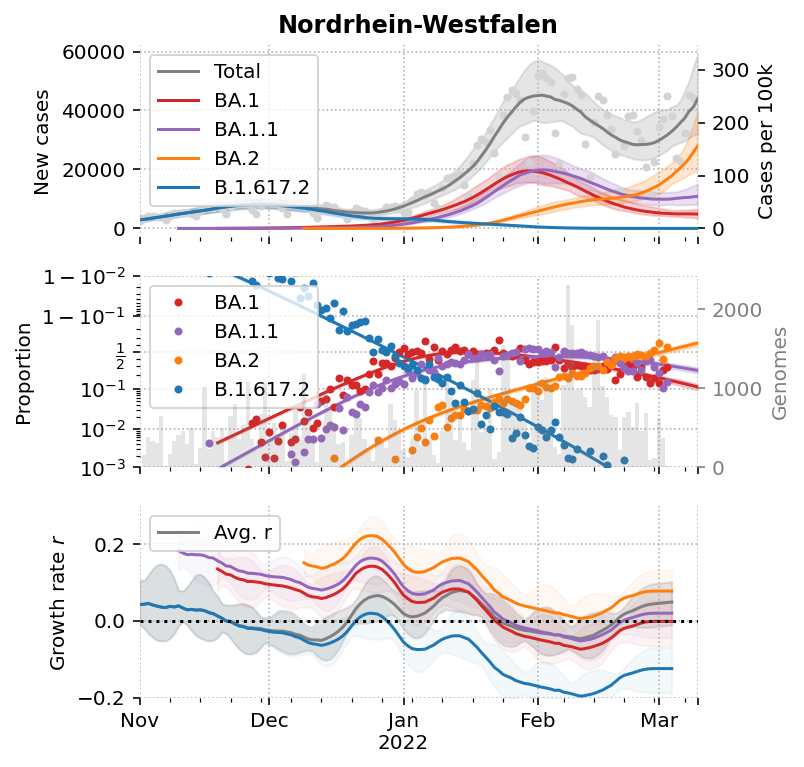

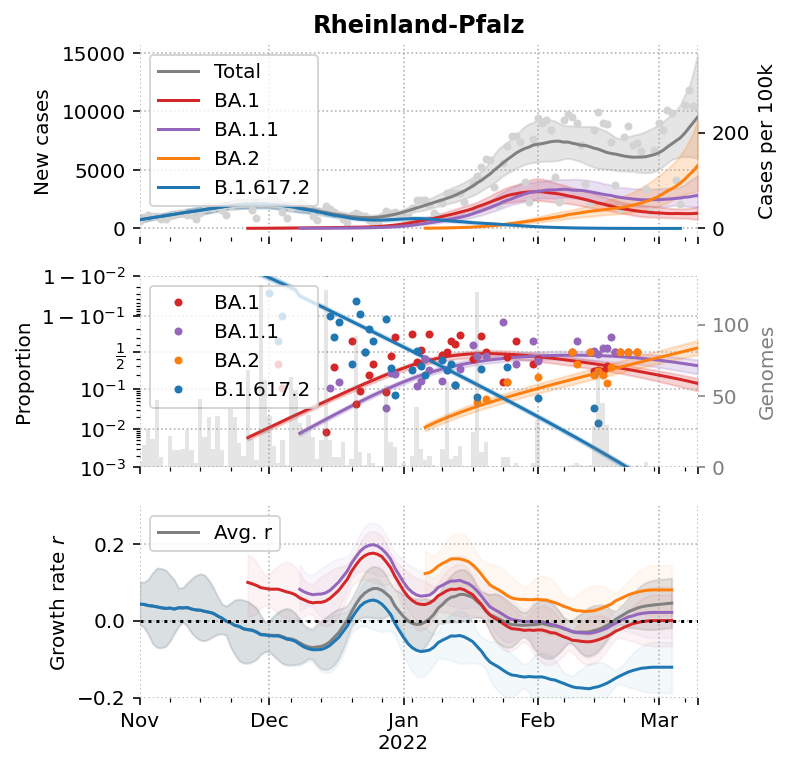

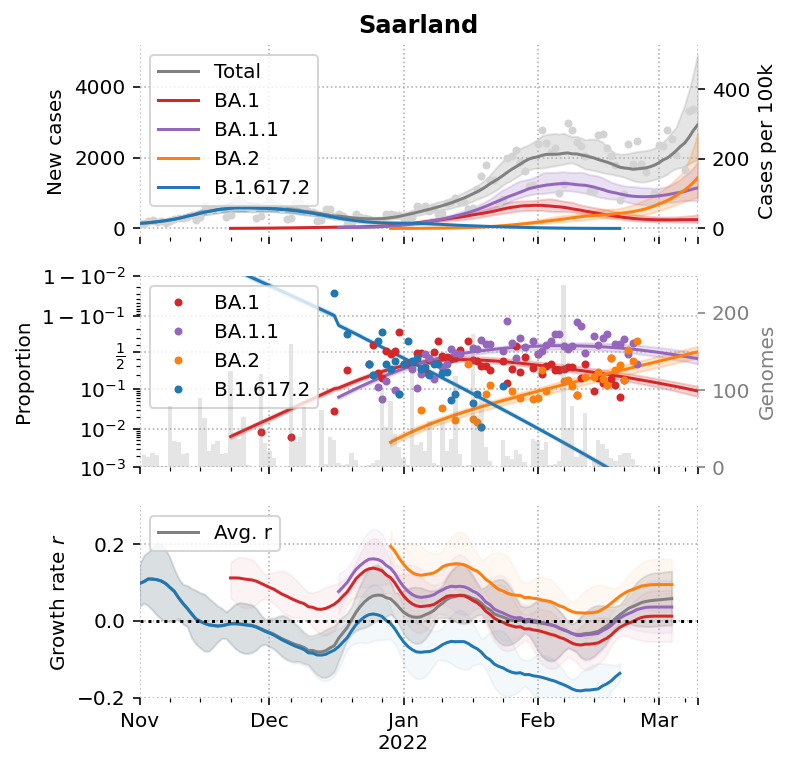

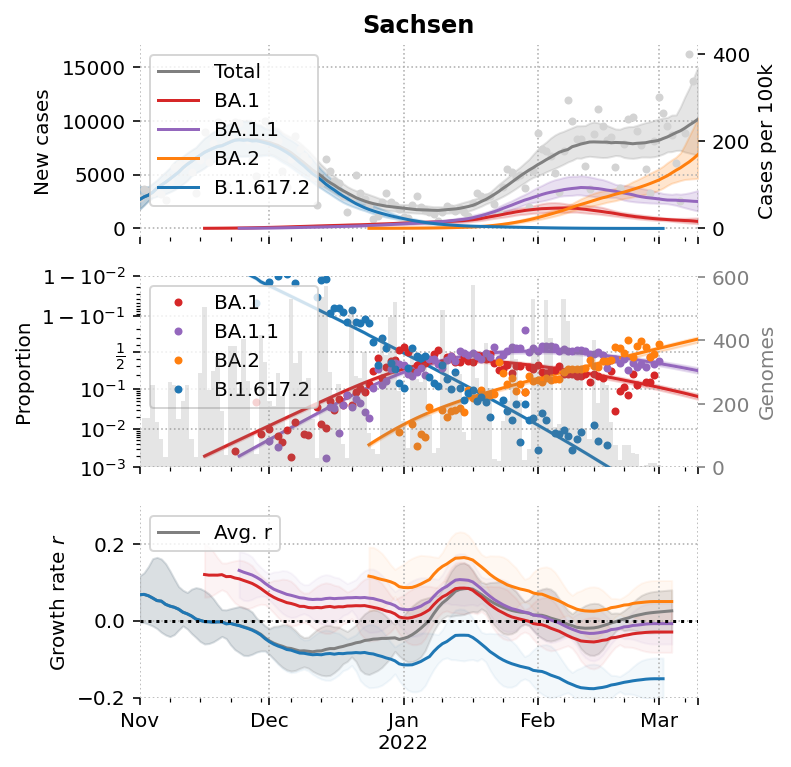

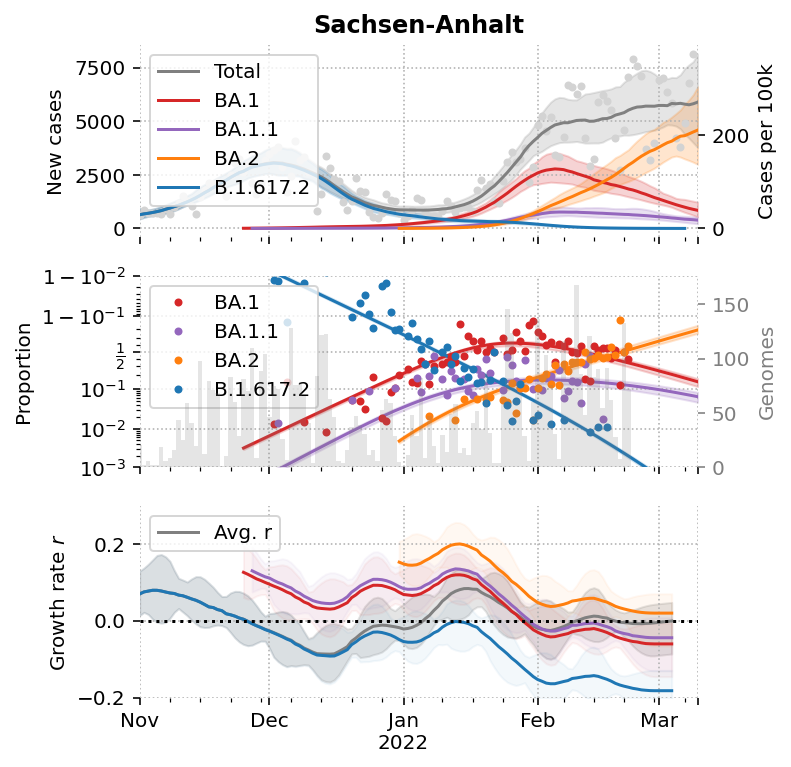

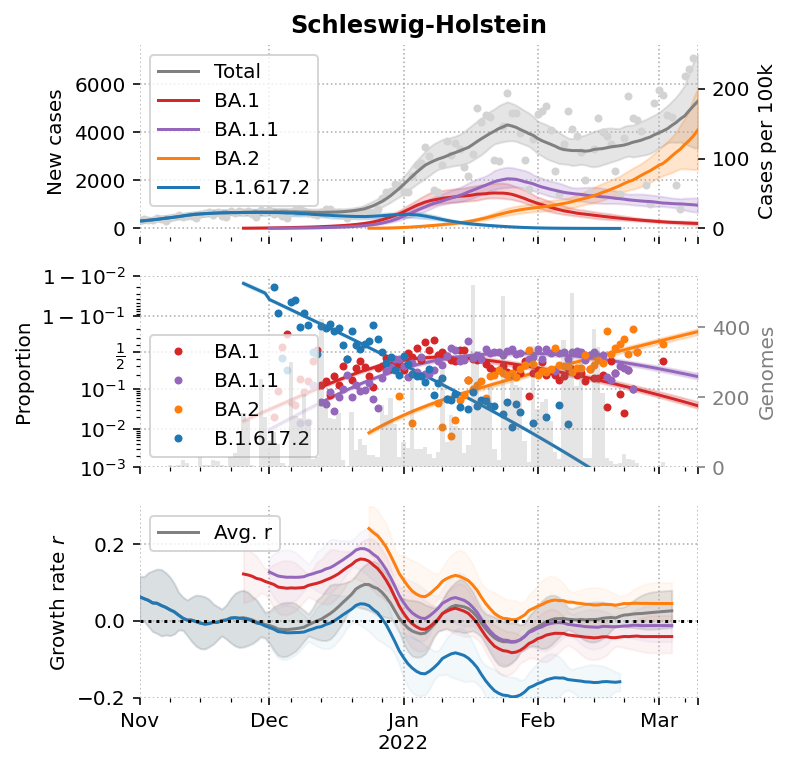

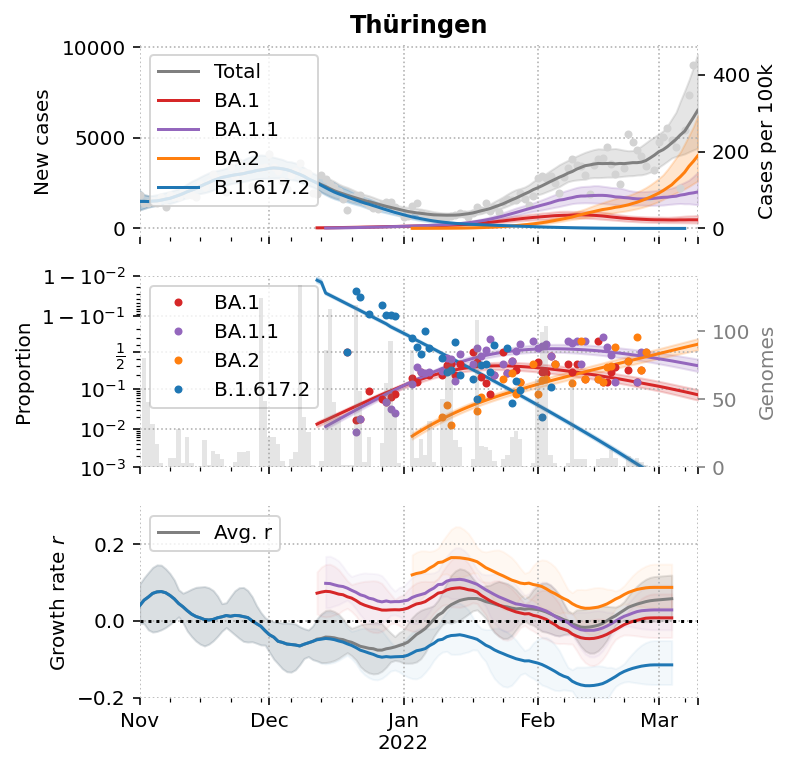

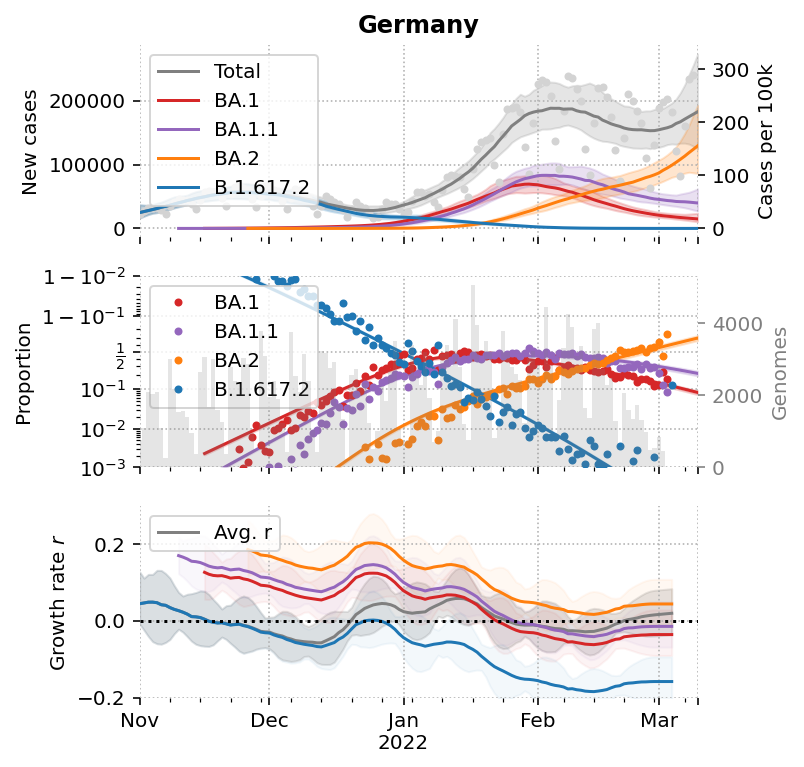

In [710]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [711]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [712]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

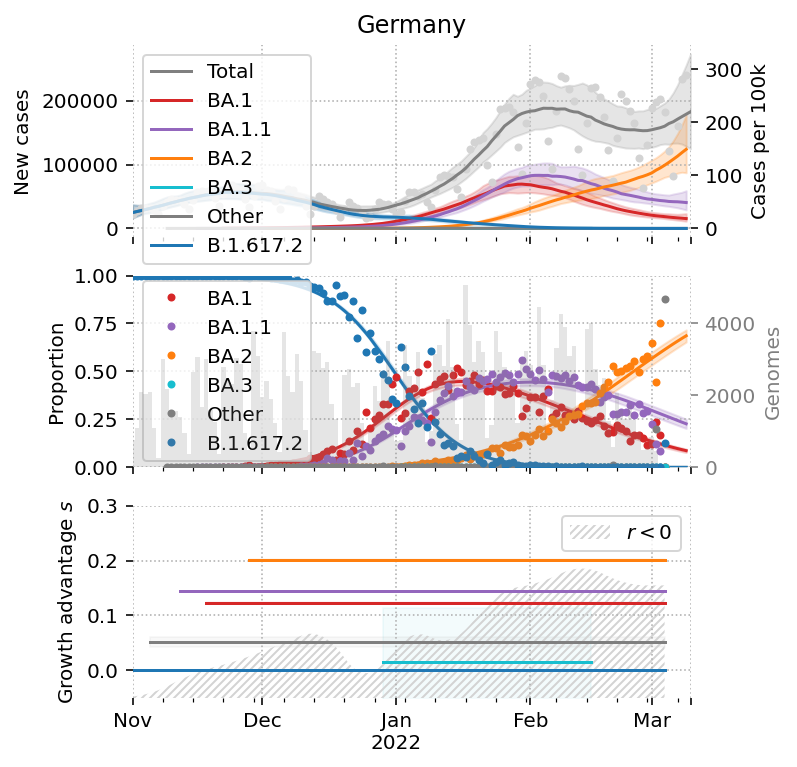

In [713]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [714]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [715]:
λ.shape

(17, 130, 6)

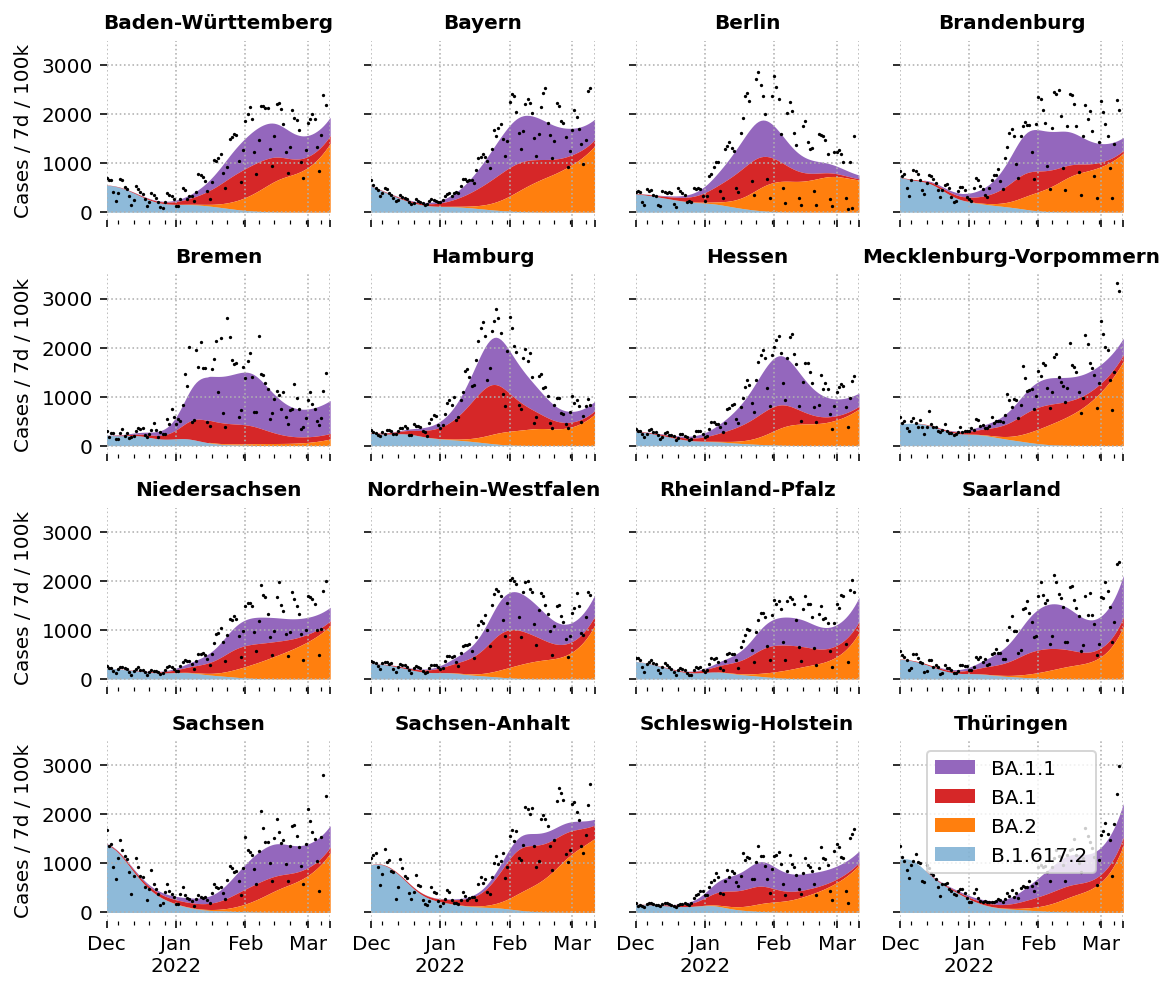

In [716]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [717]:
λ[-1,-1] / λ[-1,-1].sum()

array([8.19144439e-02, 2.18012433e-01, 7.00015224e-01, 1.68930592e-05,
       1.01231013e-05, 3.08820239e-05])

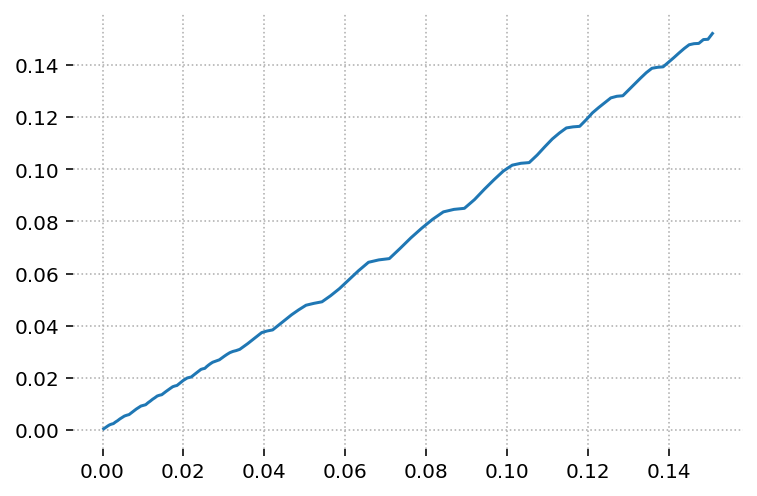

In [718]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [719]:
from genomicsurveillance.misc import get_transmissibility

In [720]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.122494  0.144007  0.201527  0.020176  0.046766   
Bayern                  0.122435  0.143825  0.201525  0.022036  0.048165   
Berlin                  0.118854  0.142216  0.201508  0.022036  0.046944   
Brandenburg             0.116288  0.141692  0.201523  0.020518  0.048885   
Bremen                  0.122448  0.143904  0.189280  0.022036  0.049909   
Hamburg                 0.116330  0.140678  0.201529  0.021038  0.048616   
Hessen                  0.117557  0.142654  0.201521  0.020737  0.047688   
Mecklenburg-Vorpommern  0.122039  0.143962  0.201472  0.022036  0.048885   
Niedersachsen           0.122289  0.143972  0.201503  0.022036  0.047127   
Nordrhein-Westfalen     0.122483  0.144004  0.201533  0.020191  0.046638   
Rheinland-Pfalz         0.121907  0.143987  0.201400  0.022036  0.047045   
Saarland                0.119286  0.144003  0.201488  0.022036  0.046882   
Sachsen                 0.122215  0.144010  0.201525  0.020290  0.048135   
Sachsen-Anhalt          0.122509  0.137715  0.201517  0.021970  0.048885   
Schleswig-Holstein      0.116324  0.143984  0.201517  0.020281  0.047083   
Thüringen               0.122438  0.143970  0.201472  0.022036  0.047133   
Germany                 0.122413  0.143969  0.201533  0.022871  0.051209   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       111630                   0.119355  0.002497   
BA.1.1     121338                   0.140846  0.001709   
BA.2        50396                   0.192551  0.002963   
BA.3           64                   0.022036  0.020299   
Other         612                   0.048885  0.004086   
B.1.617.2  237648                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.002497  
BA.1.1                           0.022485  0.001709  
BA.2                             0.080180  0.002963  
BA.3                            -0.099709  0.020299  
Other                           -0.072796  0.004086  
B.1.617.2                       -0.120606  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:912: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


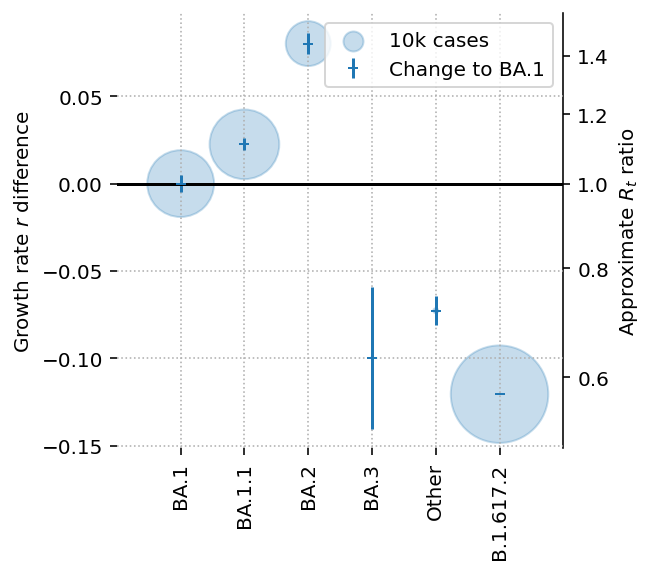

In [721]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [722]:
import geopandas as gpd

In [723]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [724]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [725]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-28     0       0     0     0      0          0
                  2022-03-01     0       0     0     0      0          0
                  2022-03-02     0       0     0     0      0          0
                  2022-03-03     0       0     0     0      0          0
                  2022-03-04     0       0     0     0      0          0

[1984 rows x 6 columns]

In [726]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([7.94192185e-02, 2.41970647e-01, 6.77351545e-01, 1.15691668e-03,
       5.68679041e-05, 4.48048852e-05])

In [727]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


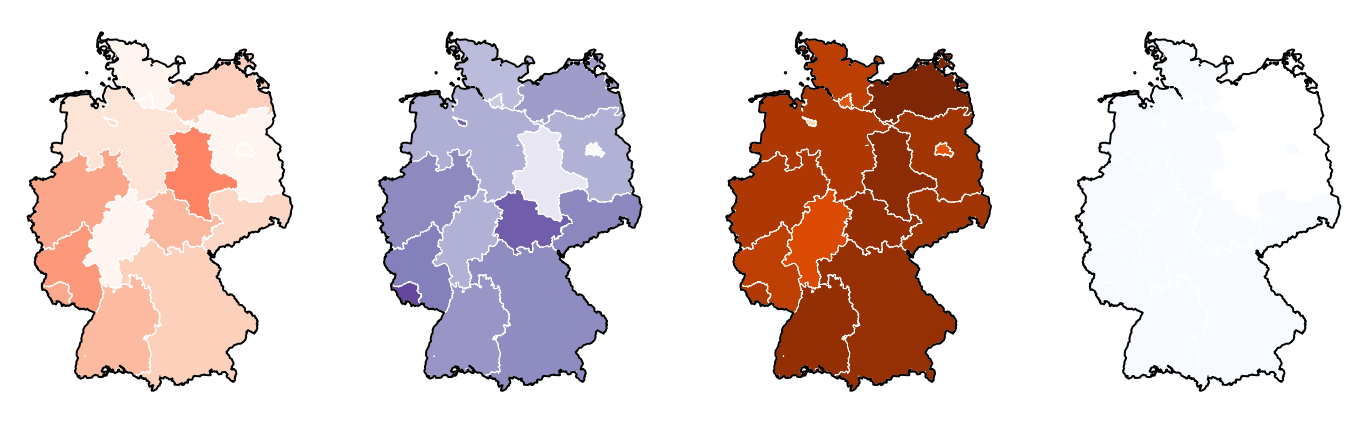

In [728]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [729]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1        BA.1.1          BA.2        BA.3  \
bundesland                                                                    
Baden-Württemberg       2476.872352   5925.637949  22310.485745    0.062859   
Bayern                  2366.159154   7928.225855  25327.745077    0.000000   
Berlin                   122.181841    404.160172   3443.469379    0.000000   
Brandenburg              187.679676    970.501806   4354.125792    1.207975   
Bremen                   108.922630    653.255470    132.110282    0.000000   
Hamburg                  181.889618    512.460735   1694.706633    0.801258   
Hessen                   475.204109   2430.561860   6733.622725    1.219366   
Mecklenburg-Vorpommern   292.095763    784.915212   3967.455632    0.000000   
Niedersachsen           1127.594171   3168.308787  12443.672379    0.000000   
Nordrhein-Westfalen     4896.059887  11074.703929  27905.787204  148.757198   
Rheinland-Pfalz         1276.089539   2920.629681   5553.429093    0.000000   
Saarland                 260.858646   1200.299410   1511.757962    0.000000   
Sachsen                  677.275142   2554.762312   7038.137185  141.744939   
Sachsen-Anhalt           842.463364    377.105063   4706.085001    0.183894   
Schleswig-Holstein       206.602397    985.947332   4019.016837    0.110146   
Thüringen                486.826447   2092.907015   4156.624029    0.000000   

                           Other  B.1.617.2  
bundesland                                   
Baden-Württemberg       0.429819   1.456000  
Bayern                  0.373930   0.848081  
Berlin                  0.081170   0.031449  
Brandenburg             0.000000   0.140405  
Bremen                  0.033067   0.016636  
Hamburg                 0.020814   0.034236  
Hessen                  7.723253   0.133482  
Mecklenburg-Vorpommern  0.000000   0.250328  
Niedersachsen           0.241285   0.569376  
Nordrhein-Westfalen     0.268751   1.385461  
Rheinland-Pfalz         0.379001   0.657128  
Saarland                0.192996   0.102410  
Sachsen                 0.051929   0.302439  
Sachsen-Anhalt          0.000000   0.683718  
Schleswig-Holstein      0.030806   0.063621  
Thüringen               0.914452   0.745895

In [730]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.03120585, -0.00966503,  0.04779236, -0.14437282, -0.10572557,
        -0.15368219],
       [-0.04692363, -0.02540465,  0.03206012, -0.1693075 , -0.1211487 ,
        -0.1693075 ],
       [-0.10133267, -0.07801267, -0.01880414, -0.22023679, -0.17022668,
        -0.22023679],
       [-0.05681787, -0.0314809 ,  0.02823169, -0.15315057, -0.17315269,
        -0.17315269],
       [ 0.00173238,  0.02254783,  0.06889013, -0.12129199, -0.07514881,
        -0.12129199],
       [-0.02580124, -0.00159075,  0.05942073, -0.1382478 , -0.09365011,
        -0.14222864],
       [-0.04564636, -0.02079753,  0.03823523, -0.1498861 , -0.09894137,
        -0.16329692],
       [-0.03522007, -0.01331824,  0.04411359, -0.15738329, -0.15738329,
        -0.15738329],
       [-0.04460265, -0.02284247,  0.03470368, -0.16676543, -0.11974768,
        -0.16676543],
       [-0.00251844,  0.01897963,  0.07657396, -0.10291457, -0.0795149 ,
        -0.12505038],
       [ 0.00125283,  0.02306693,  0.08026621, -0.

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


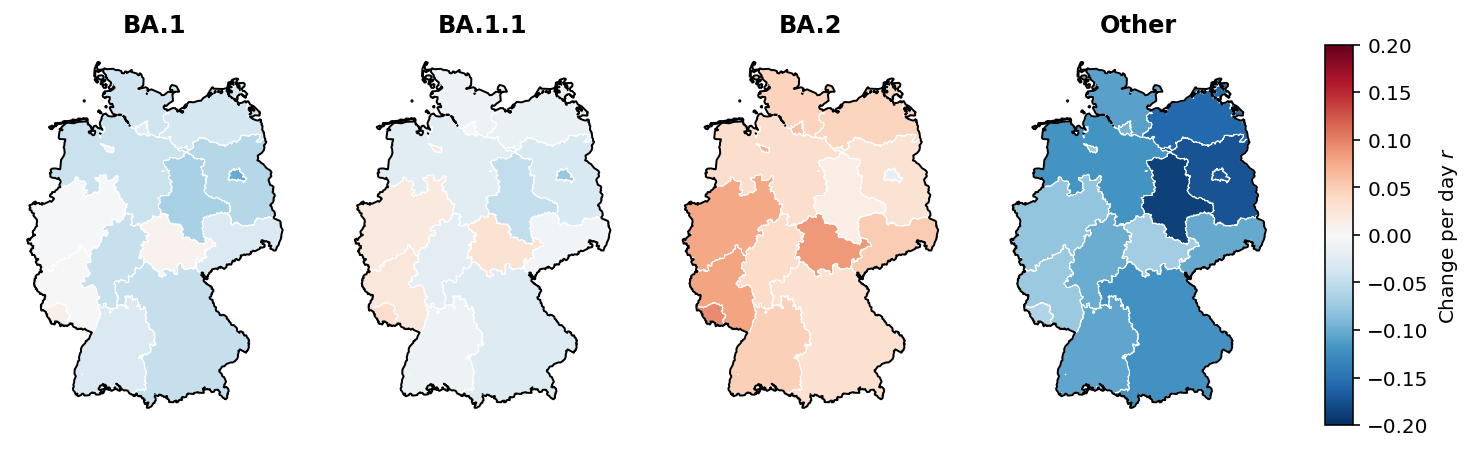

In [731]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [736]:
i = -24
ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,i,2], (0.1, 0.9), axis=0)
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,i,:]

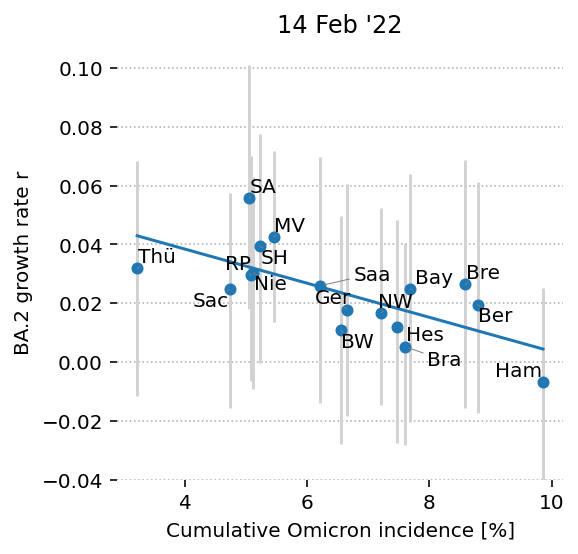

In [737]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
plt.figure(figsize=(4,4))
lr = LR()
x = λ[...,:i,:3].sum((1,2)) * 100
y = r[:,2]
lr.fit(x[:,np.newaxis], y)
plt.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color='C0', ecolor='lightgrey')
plt.title(cases_land.columns[i].strftime("%-d %b \'%y"))
import re
l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
text=[]
for i in range(x.shape[0]):
    text.append(plt.text(x[i], y[i], l[i], color='k', va='center', ha='center'))
x.sort()
y = lr.predict(x[:,np.newaxis])
line = plt.plot(x, y, ls="-")
#plt.axline((0, lr.intercept_), slope=lr.coef_)
#plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
plt.xlabel("Cumulative Omicron incidence [%]")
plt.ylabel("BA.2 growth rate r")
plt.ylim((-0.04,None))
adjust_text(text, 
            #add_objects=line, 
            #expand_objects = (1,1),
            #force_objects =  (0, 0.2),
            #only_move=dict(objects='y', text='y', points='y'),
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5), )
plt.grid(axis='x', which='major')

In [734]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

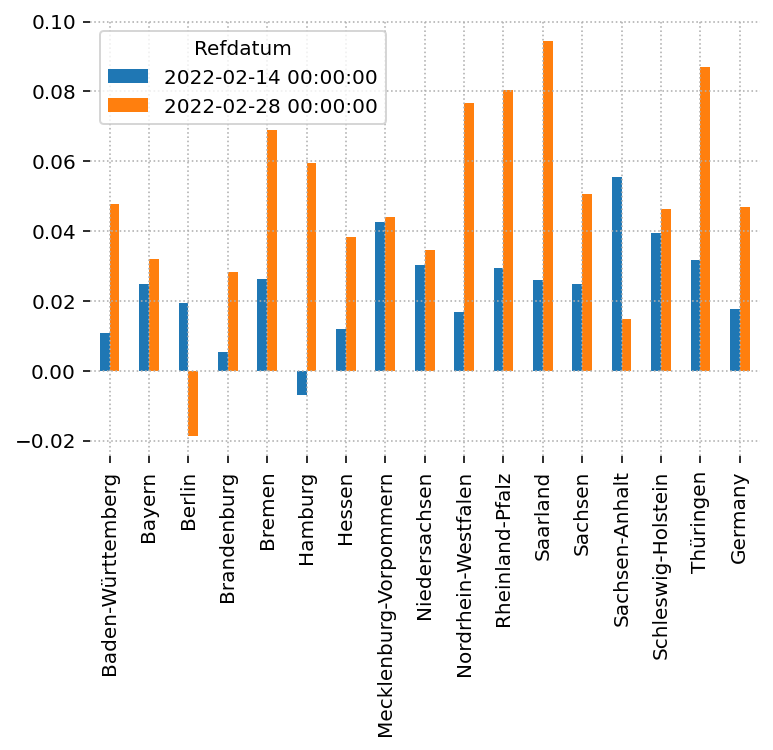

In [735]:
d.plot.bar()

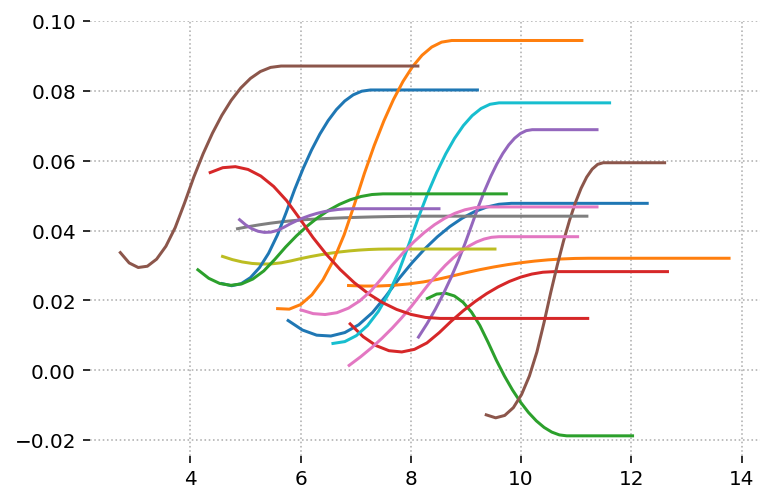

In [738]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


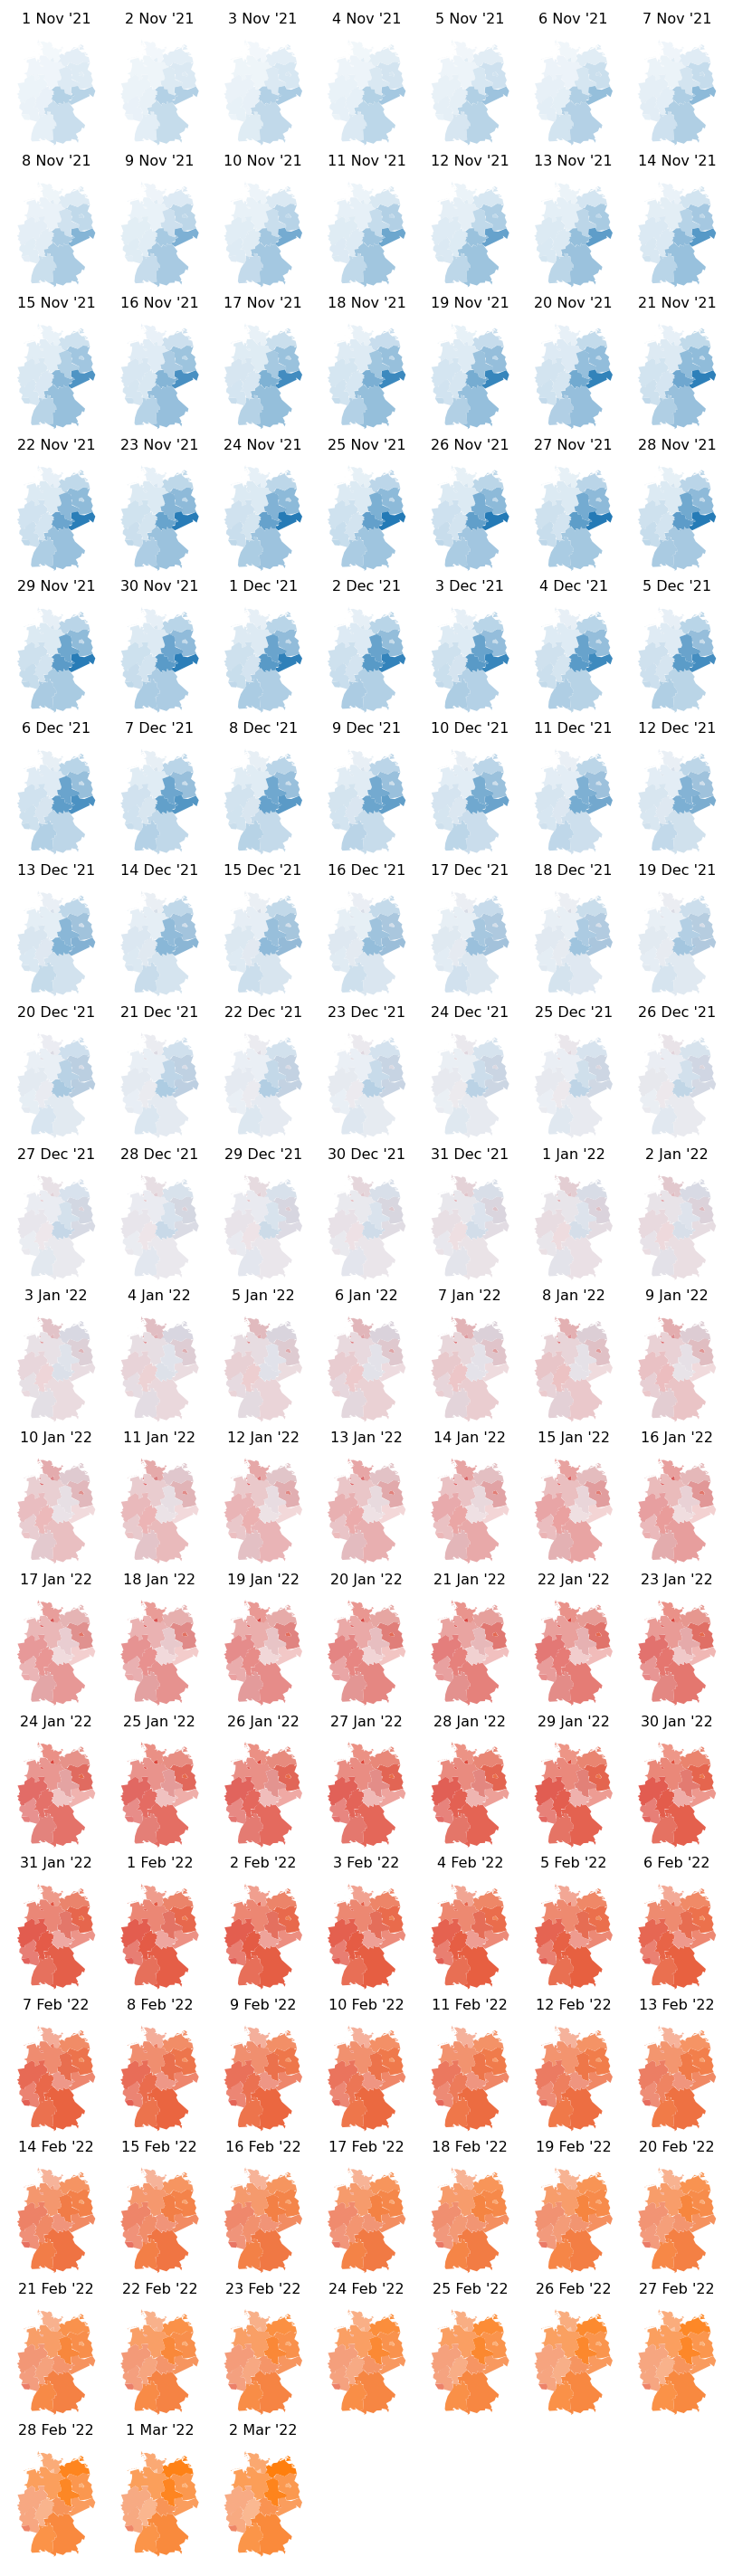

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


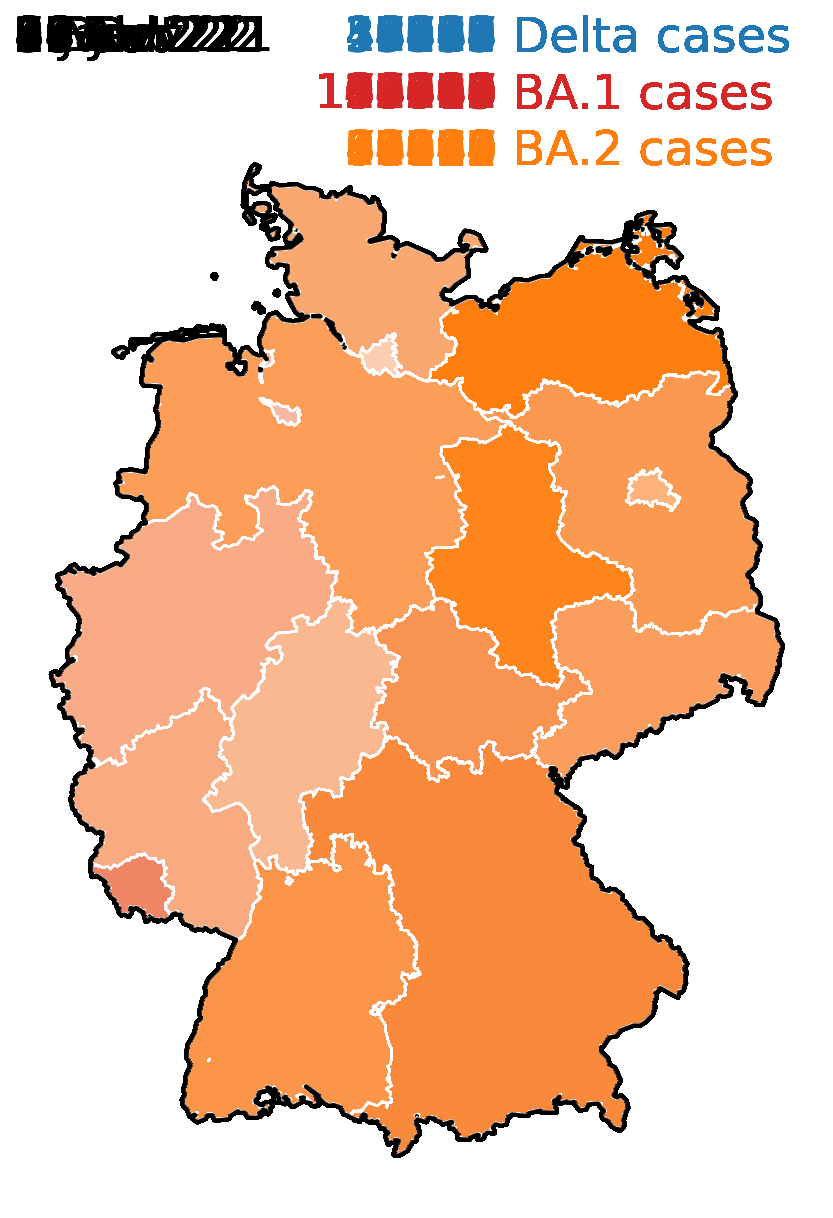

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

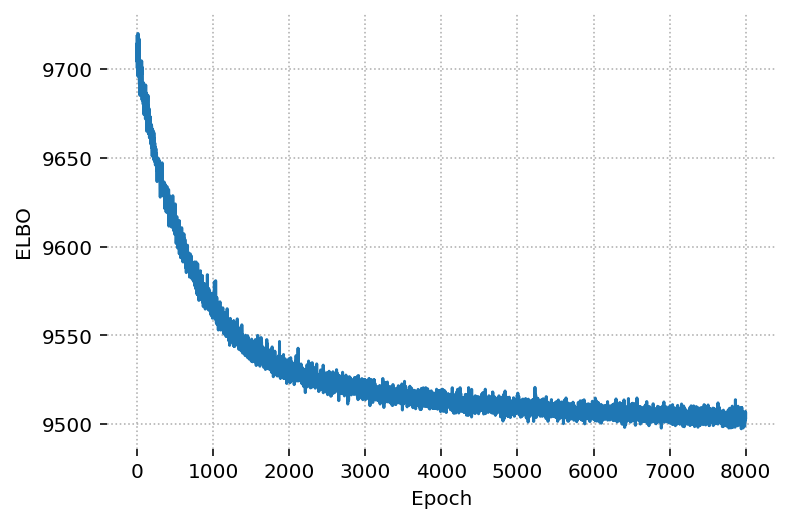

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

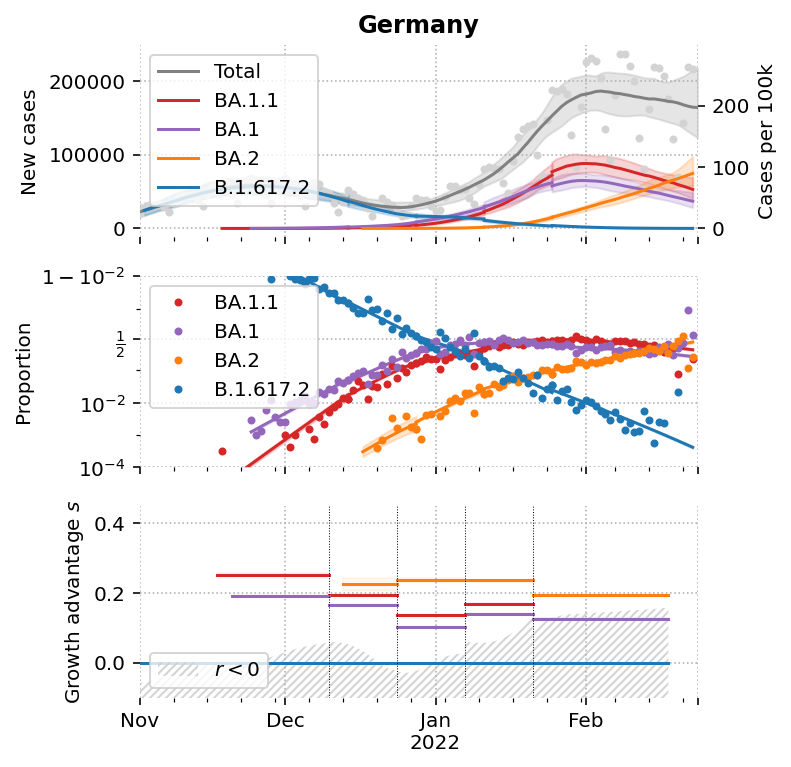

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


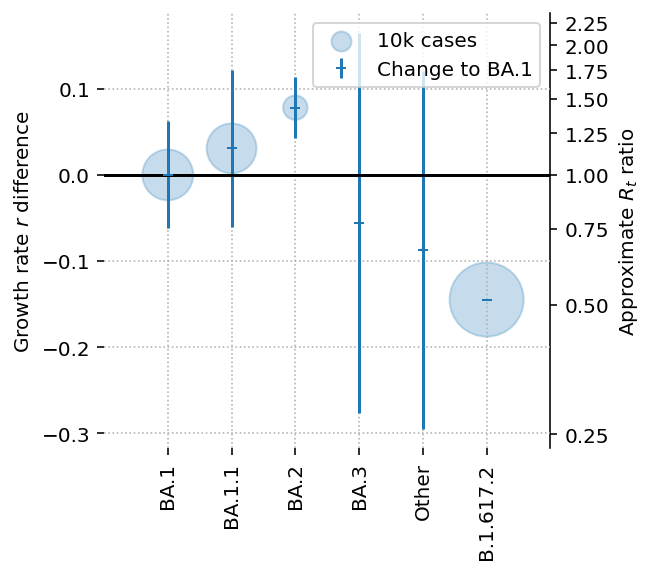

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
